# denoising net

In [26]:
from __future__ import print_function
import matplotlib.pyplot as plt
%matplotlib inline

import os
import time
import cv2
os.environ['CUDA_VISIBLE_DEVICES'] = '0'

import numpy as np
from models import *
from skimage.measure import compare_psnr

import torch
import torch.optim
 
from utils.denoising_utils import *

torch.backends.cudnn.enabled = True
torch.backends.cudnn.benchmark =True
dtype = torch.FloatTensor

imsize = (480, 320) # change -1
PLOT = True
sigma = 25
sigma_ = sigma/255.

In [23]:
fname = 'data/denoising/snail.jpg'

In [18]:
INPUT = 'noise' # 'meshgrid'
pad = 'reflection'
OPT_OVER = 'net' # 'net,input'

reg_noise_std = 1./30. # set to 1./20. for sigma=50
LR = 0.01

OPTIMIZER='adam' # 'LBFGS'
show_every = 100
exp_weight=0.99


num_iter = 24000
input_depth = 3
figsize = 5 
    
net = skip(
                input_depth, 3, 
                num_channels_down = [8, 16, 32, 64, 128], 
                num_channels_up   = [8, 16, 32, 64, 128],
                num_channels_skip = [0, 0, 0, 4, 4], 
                upsample_mode='bilinear',
                need_sigmoid=True, need_bias=True, pad=pad, act_fun='LeakyReLU')

net = net.type(dtype)

In [19]:
#net_input = get_noise(input_depth, INPUT, (img_pil.size[1], img_pil.size[0])).type(dtype).detach()
net_input =  np_to_torch(img_np).type(dtype)

# Compute number of parameters
s  = sum([np.prod(list(p.size())) for p in net.parameters()]); 
print ('Number of params: %d' % s)

# Loss
mse = torch.nn.MSELoss().type(dtype)

img_noisy_torch = np_to_torch(img_noisy_np).type(dtype)

Number of params: 572827


In [24]:
# list data

from os import listdir
from os.path import isfile, join

#  'data/train2014/'# 
data_path = '/home/usergpu/dev/data/'# 'data/train2014/'#'/home/user/dev/generative_inpainting/data/training/'
onlyfiles = [f for f in listdir(data_path) if isfile(join(data_path, f))]
print(len(onlyfiles))
train_data = [data_path + f for f in onlyfiles]

3173


Starting optimization with ADAM


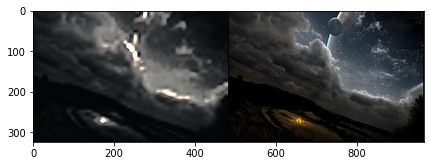

In [ ]:
net_input_saved = net_input.detach().clone()
noise = net_input.detach().clone()
out_avg = None
last_net = None
psrn_noisy_last = 0

i = 0
plot_counter =0
def closure():
    
    global i, out_avg, psrn_noisy_last, last_net, net_input,plot_counter
    
    
    index = np.random.randint(len(train_data), size=1)[0]
    fname = train_data[index]
    
    try:
        img_pil, img_np = get_image(fname, imsize)
    except Exception as e:
            print(e)
            return 0.01
    img_noisy_pil = crop_image(img_pil, d=32)
    img_noisy_np = pil_to_np(img_noisy_pil) 
    net_input = np_to_torch(img_noisy_np).type(dtype)
    img_torch = np_to_torch(img_np).type(dtype)
         
    try:    
        out = net(net_input)     
    except Exception as e:        
        print(e)
        return 0.1
    total_loss = mse(out, img_torch)
    total_loss.backward()
         
    
    # Note that we do not have GT for the "snail" example
    # So 'PSRN_gt', 'PSNR_gt_sm' make no sense
    print ('Iteration %05d    Loss %f ' % (i, total_loss.item()), '\r', end='')
    if  PLOT and i % 5000 == 0:
        out_np = torch_to_np(out)
        plot_image_grid([np.clip(out_np, 0, 1),np.clip(img_noisy_np, 0, 1)], factor=figsize, nrow=2) 
        plot_counter+=1
        
    if i % 50000 == 0:
        ts = time.time()
        fpath = 'tmp/file_den_%d_%d.net' % (ts, i)
        torch.save(net, fpath) 
            
    i += 1

    return total_loss


num_iter = 3000 * len(train_data)

p = get_params(OPT_OVER, net, net_input)
optimize(OPTIMIZER, p, closure, LR, num_iter)

In [ ]:
ts = time.time()
fpath = 'tmp/file_den_%d_%d.net' % (ts, i)
torch.save(net, fpath)

In [ ]:
2831_Y1X8GTE